In [2]:
import numpy as np
import pandas as pd
house = pd.read_csv("/Users/marvinlee/Documents/vs_code/gsb_544/lab/final/train_new.csv")

# 1. Cleaning

## a. drop nas

In [77]:
house.isna().sum().sum()

363

In [78]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2197 entries, 0 to 2196
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SalePrice      2197 non-null   int64  
 1   PID            2197 non-null   int64  
 2   Lot Frontage   1835 non-null   float64
 3   Lot Area       2197 non-null   int64  
 4   Street         2197 non-null   object 
 5   Neighborhood   2197 non-null   object 
 6   Bldg Type      2197 non-null   object 
 7   House Style    2197 non-null   object 
 8   Overall Qual   2197 non-null   int64  
 9   Overall Cond   2197 non-null   int64  
 10  Year Built     2197 non-null   int64  
 11  Roof Style     2197 non-null   object 
 12  Heating        2197 non-null   object 
 13  Central Air    2197 non-null   object 
 14  Electrical     2196 non-null   object 
 15  Full Bath      2197 non-null   int64  
 16  Half Bath      2197 non-null   int64  
 17  Bedroom AbvGr  2197 non-null   int64  
 18  TotRms A

In [79]:
good_cols = house.isna().sum() < 100
house_clean = house.loc[:,good_cols]

# Drop other NAs
house_clean = house_clean.dropna()

In [80]:
house_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2196 entries, 0 to 2196
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   SalePrice      2196 non-null   int64 
 1   PID            2196 non-null   int64 
 2   Lot Area       2196 non-null   int64 
 3   Street         2196 non-null   object
 4   Neighborhood   2196 non-null   object
 5   Bldg Type      2196 non-null   object
 6   House Style    2196 non-null   object
 7   Overall Qual   2196 non-null   int64 
 8   Overall Cond   2196 non-null   int64 
 9   Year Built     2196 non-null   int64 
 10  Roof Style     2196 non-null   object
 11  Heating        2196 non-null   object
 12  Central Air    2196 non-null   object
 13  Electrical     2196 non-null   object
 14  Full Bath      2196 non-null   int64 
 15  Half Bath      2196 non-null   int64 
 16  Bedroom AbvGr  2196 non-null   int64 
 17  TotRms AbvGrd  2196 non-null   int64 
 18  Gr Liv Area    2196 non-null   in

In [81]:
house_clean.isna().sum().sum()

0

In [82]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
import plotnine as p9

In [83]:
X = house_clean.drop(["SalePrice","PID"], axis = 1)
y = house_clean["SalePrice"]

In [84]:
log_y = np.log(y)
log_y.head()

0    11.976659
1    12.513190
2    11.831379
3    12.423198
4    12.025749
Name: SalePrice, dtype: float64

In [85]:
nor_y = np.exp(log_y)
nor_y.head()

0    159000.0
1    271900.0
2    137500.0
3    248500.0
4    167000.0
Name: SalePrice, dtype: float64

In [86]:
X_corr = house_clean.drop(["PID","Street","Neighborhood",'Bldg Type',"House Style","Roof Style", "Heating", "Central Air", "Electrical", "Functional", "Sale Type"], axis = 1)

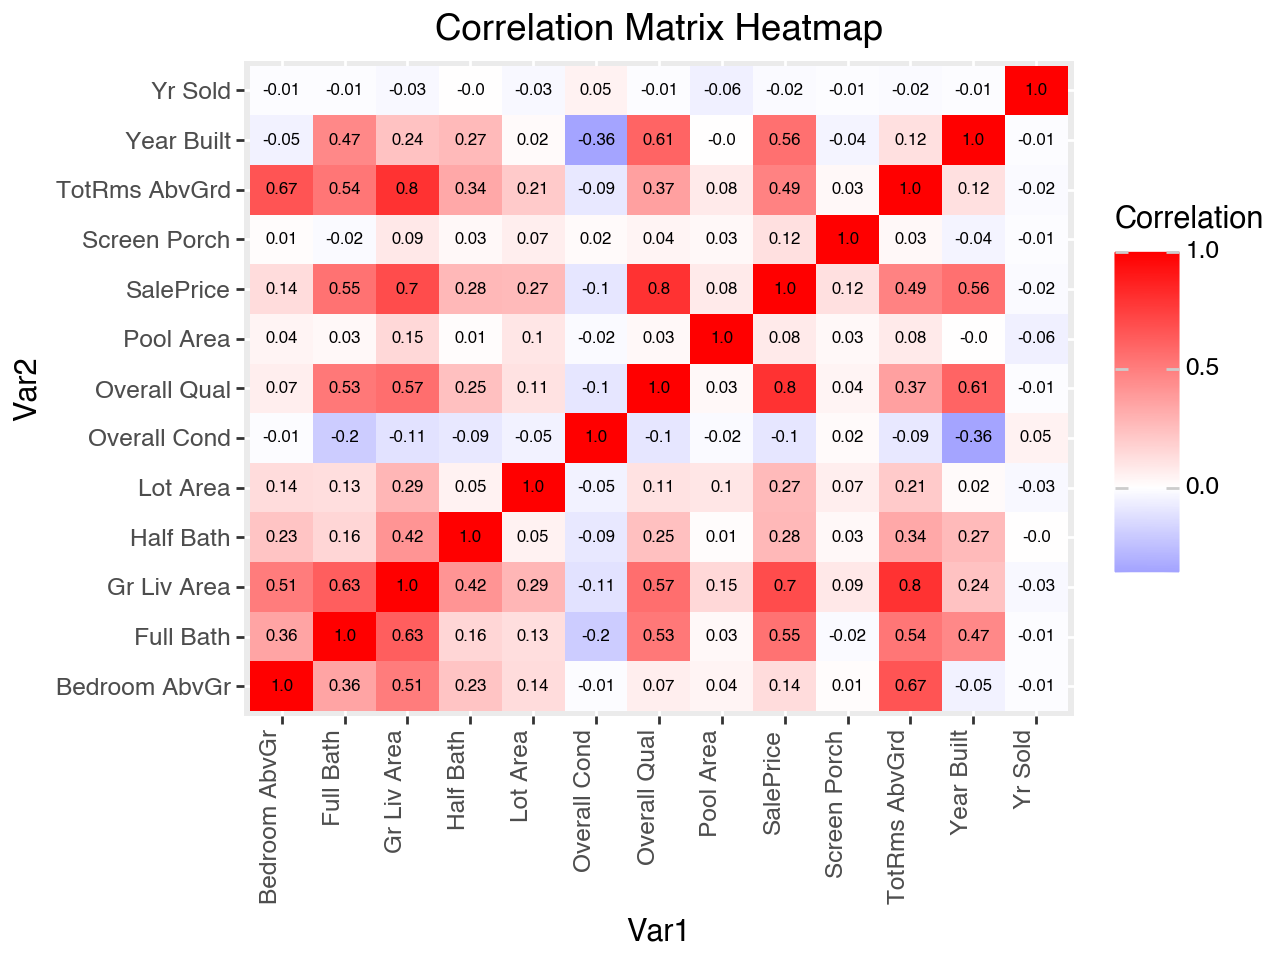

In [87]:
correlation_matrix = X_corr.corr().reset_index()
# Convert the correlation matrix into long format
corr_long = correlation_matrix.melt(id_vars='index')
corr_long.columns = ['Var1', 'Var2', 'Correlation']
corr_long['Correlation'] = corr_long['Correlation'].round(2)
(p9.ggplot(corr_long) +
p9.aes(x='Var1', y='Var2', fill='Correlation') +
p9.geom_tile() +
p9.geom_text(p9.aes(label='Correlation'), color='black', size=6) +
p9.scale_fill_gradient2(low='blue', high='red', mid='white', midpoint=0) +
p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1),
          axis_text_y=p9.element_text(rotation=0, hjust=1)) +
p9.labs(title='Correlation Matrix Heatmap')
)

# 2. Modelling

In [88]:
def model_try(model, cat, num):
  ct = ColumnTransformer(
    [
      ("dummify",
      OneHotEncoder(drop='first', sparse_output = False, handle_unknown='ignore'), cat),
      ("standardize", StandardScaler(), num)
    ],remainder = "drop"
    )

  pipeline = Pipeline(
    [("preprocessing", ct),
    ("model", model)] # the only changing part
  )
  return pipeline

## a.Lasso

In [89]:
cat_lasso = make_column_selector(dtype_include="object")(X)
num_lasso = make_column_selector(dtype_include="number")(X)
param_lasso = {
    'model__alpha': np.logspace(-3, 1, num=5)
}

print("Categorical columns:", cat_lasso)
print("Numerical columns:", num_lasso)

Categorical columns: ['Street', 'Neighborhood', 'Bldg Type', 'House Style', 'Roof Style', 'Heating', 'Central Air', 'Electrical', 'Functional', 'Sale Type']
Numerical columns: ['Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'TotRms AbvGrd', 'Gr Liv Area', 'Screen Porch', 'Pool Area', 'Yr Sold']


In [90]:
param_grid = {
    'model__alpha': np.logspace(-3, 1, num=5)
}
model_lasso = model_try(Lasso(), cat_lasso, num_lasso)
gs_lasso = GridSearchCV(model_lasso, param_grid, cv = 5, scoring=['neg_root_mean_squared_error', 'r2'],
        refit='neg_root_mean_squared_error'
    )
gs_lasso_fitted = gs_lasso.fit(X, log_y)
gs_lasso_fitted.cv_results_

param_columns = [col for col in gs_lasso_fitted.cv_results_ if col.startswith('param_')]
param_values = {col: gs_lasso_fitted.cv_results_[col] for col in param_columns}

    # Extract scores for each metric
results = pd.DataFrame({
        **param_values,
        "neg_rmse": gs_lasso.cv_results_['mean_test_neg_root_mean_squared_error'],
        "r2": gs_lasso.cv_results_['mean_test_r2']
})

    # Sort by the primary refit score (neg_rmse in this case)
results = results.sort_values(by="neg_rmse", ascending=False)
results

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [1, 7] during transform. These unknown categories will be encoded as all zeros
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [1, 5, 8] during transform. These unknown categories will be encoded as all zeros
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [8, 9] during transform. These unknown categories will be encoded as all zeros
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [1, 7] during transform. These unknown categories will be encoded as all zeros
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [1, 5, 8] during

,param_model__alpha,neg_rmse,r2
0,0.001,-0.150614,0.862915
1,0.01,-0.169194,0.827703
2,0.1,-0.224656,0.699084
3,1.0,-0.410606,-0.005045
4,10.0,-0.410606,-0.005045


## b. Elastic

In [91]:
print("Categorical columns:", cat_lasso)
print("Numerical columns:", num_lasso)

Categorical columns: ['Street', 'Neighborhood', 'Bldg Type', 'House Style', 'Roof Style', 'Heating', 'Central Air', 'Electrical', 'Functional', 'Sale Type']
Numerical columns: ['Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'TotRms AbvGrd', 'Gr Liv Area', 'Screen Porch', 'Pool Area', 'Yr Sold']


In [98]:
param_elastic = {
    'model__alpha': np.logspace(-4, 2, num=7),   # Explore alpha values from 10^-5 to 10^5
    'model__l1_ratio': np.linspace(0.1, 1, 10)   # Explore l1_ratio values from 0 to 1
}
model_elastic = model_try(ElasticNet(max_iter = 1000000000), cat_lasso, num_lasso)
gs_elastic = GridSearchCV(model_elastic, param_elastic, cv = 5, scoring=['neg_root_mean_squared_error', 'r2'],
        refit='neg_root_mean_squared_error', n_jobs = -1
    )
gs_elastic_fitted = gs_elastic.fit(X, log_y)
gs_elastic_fitted.cv_results_

param_columns = [col for col in gs_elastic_fitted.cv_results_ if col.startswith('param_')]
param_values = {col: gs_elastic_fitted.cv_results_[col] for col in param_columns}

    # Extract scores for each metric
result2 = pd.DataFrame({
        **param_values,
        "neg_rmse": gs_elastic.cv_results_['mean_test_neg_root_mean_squared_error'],
        "r2": gs_elastic.cv_results_['mean_test_r2']
})

    # Sort by the primary refit score (neg_rmse in this case)
result2 = result2.sort_values(by="neg_rmse", ascending=False)
result2

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [1, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [1, 5, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [1, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:24

,param_model__alpha,param_model__l1_ratio,neg_rmse,r2
11,0.001,0.2,-0.147622,0.868473
12,0.001,0.3,-0.147801,0.868106
10,0.001,0.1,-0.147899,0.868073
9,0.0001,1.0,-0.148115,0.867753
13,0.001,0.4,-0.148150,0.867419
...,...,...,...,...
46,1.0,0.7,-0.410606,-0.005045
45,1.0,0.6,-0.410606,-0.005045
44,1.0,0.5,-0.410606,-0.005045
43,1.0,0.4,-0.410606,-0.005045


In [99]:
house_test = pd.read_csv("lab/final/test_new.csv")

In [100]:
best_model_ela = gs_elastic_fitted.best_estimator_

y_pred = np.exp(best_model_ela.predict(house_test))

In [104]:
pred_df = pd.DataFrame(y_pred, columns=['SalePrice'])

# Combine the 'pid' column from house_test with the predictions
result_df3 = pd.concat([house_test['PID'], pred_df], axis=1)

# Display the result
print(result_df2)

           PID      SalePrice
0    907135180  126905.577379
1    528181040  219959.514619
2    528175010  219375.671700
3    531379030  185771.372162
4    923275090  128411.289039
..         ...            ...
600  528174060  181538.648655
601  903400180  175826.602191
602  903227150  131687.797897
603  909250070  160125.075721
604  909425180  198381.419501

[605 rows x 2 columns]


In [105]:
result_df3.to_csv('lab/final/result_df3.csv', index=False)